In [343]:
%run ./reccap2ocean_regions.py

In [1]:
%pylab inline
import xarray as xr
import pandas as pd
import ocean_data_tools as odt
import cartopy as ctp

Populating the interactive namespace from numpy and matplotlib


In [10]:
def make_fig(xda, **kwargs):
    ax = xda.plot_map(proj=ctp.crs.PlateCarree(-155), **kwargs)
    fig = ax.get_figure()
    return fig, ax

# Defining the global basins

Below is an annotated figure of the proposed basins for RECCAP2-ocean. 
The majority of the boundaries for the basins are relatively straight forward. 
The boundaries are defined in one of three ways: CO2 biomes by [Fay and McKinley (2014)](https://doi.org/10.5194/essd-6-273-2014) (FM14); the WOA (2009) ocean basin map (WOA09) [a link to LDEO data](https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NODC/.WOA09/.Masks/.basin/data.nc); manual decisions. The WOA mask might not be well known, but this doesn't matter as it serves purely as a convenient way to define the borders. 

Starting from the simplest to the boundaries where most decisions were taken, the **Southern Ocean** is defined by FM14. 
The eastern boundary of the **Indian** is defined by the WOA09 boundary between the Pacific and Indian. 
The Red Sea and the Persian Gulf have been masked. 
The authors of the Indian Ocean chapter can include this if they wish but of course this should not be a priority for the chapter. 
In the North **Pacific**, the Bearring Strait limit is also defined by WOA09. 
The **Atlantic** includes the Mediterranean Sea and Gulf of Mexico. W
e have chosen to exclude the Baltic Sea as carbon cycling and fluxes are notoriously difficult to predict in the region. 
The boundary between the **Arctic** and the Atlantic is defined by FM14 with some modifications. 
The northern boundary has manually been set to 56°N that limits the extent of FM14's biome in the Labrador Sea. 
In the far North Atlantic, the eastern extent has been set to 25°E as the most northern extent of Scandinavia. 

The faint white line marks the COSCATs definition of the coastal ocean that is one of the possible definitions of the coastal ocean. 
This is purely for demonstration. 

In [6]:
xds

<xarray.Dataset>
Dimensions:       (lat: 180, lon: 360)
Coordinates:
  * lat           (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon           (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Data variables:
    basins        (lat, lon) float64 ...
    fay_mckinley  (lat, lon) float64 ...
    woa_regions   (lat, lon) float32 ...
    atlantic      (lat, lon) float64 ...
    pacific       (lat, lon) float64 ...
    indian        (lat, lon) float64 ...
    arctic        (lat, lon) float64 ...
    southern      (lat, lon) float64 ...

adding biome contours


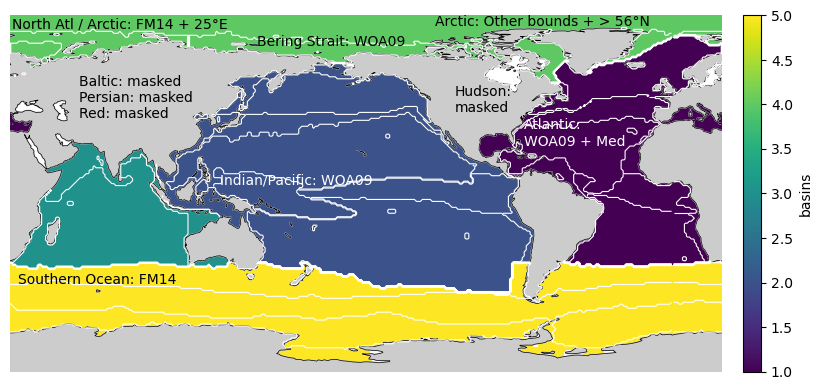

In [13]:
fig, ax = make_fig(xds.basins, cmap=cm.viridis)

add_coasts = False
add_biomes = True

if add_coasts:
    xda = xr.open_dataset('../reccap2coastal_coscats.nc').continental_shelf
    x = xda.longitude.values
    y = xda.latitude.values
    ax.contour(x, y, xda.notnull().values.astype(int), levels=[0.5], linewidths=[0.8], colors=['w'], transform=ctp.crs.PlateCarree())
if add_biomes:
    print('adding biome contours')
    xda = xds.fay_mckinley
    x = xda.lon.values
    y = xda.lat.values
    ax.contour(x, y, xda.values.astype(float), levels=np.arange(19)-.5, linewidths=[0.8], colors=['w'], transform=ctp.crs.PlateCarree(), zorder=20)
    ax.contour(x, y, xda.notnull().values.astype(float), levels=np.arange(19)-.5, linewidths=[0.8], colors=['w'], transform=ctp.crs.PlateCarree(), zorder=20)
    ax.contour(x, y, xds.basins.values.astype(float), levels=np.arange(19)-.5, linewidths=[1], colors=['w'], transform=ctp.crs.PlateCarree(), zorder=20)

props = dict(va='top', zorder=21, fontsize=10, transform=ctp.crs.PlateCarree())
ax.text(60, 60, 'Baltic: masked\nPersian: masked\nRed: masked', **props)
ax.text(-110, 55, 'Hudson:\nmasked', **props)
ax.text(26, 89, 'North Atl / Arctic: FM14 + 25°E', **props)
ax.text(150, 80, 'Bering Strait: WOA09', **props)
ax.text(29, -40, 'Southern Ocean: FM14', **props)
ax.text(131, 10, 'Indian/Pacific: WOA09', **props, color='w')
ax.text(-75, 38, 'Atlantic:\nWOA09 + Med', **props, color='w')
ax.text(-120, 90, 'Arctic: Other bounds + > 56°N', **props)
ax.outline_patch.set_lw(0)
# if add_coasts:
#     fig.savefig('../img/basin_all_wCoasts.png', bbox_inches='tight', dpi=150)
# elif add_biomes:
#     fig.savefig('../img/basin_all_wBiomes.png', bbox_inches='tight', dpi=150)
# else:
#     fig.savefig('../img/basin_all.png', bbox_inches='tight', dpi=150)

# Basin plots and sub-regions

The subregions are defined by the CO2 biomes from [Fay and McKinley (2014)](https://doi.org/10.5194/essd-6-273-2014).
These regions are defined with thresholds of the drivers of surface pCO2 (SST, max-MLD, Chl-a, sea-ice extent).
Some oceanic regions are not included in this as they fall outside the selected thresholds for the drivers. 
We have (for now) assigned these outlying patches to a single value (1).

Below is a plot showing the different regions including the coastal, and seamasks. 

In [60]:
from reccap2ocean_regions import main as reccap2_regions
from pandas import Timestamp as ts

In [61]:
sname = f'RECCAP2_region_masks_all_v{ts.today():%Y%m%d}'

In [64]:
xds = reccap2_regions()
coast = xr.open_dataarray('../RECCAP2_coastal_MARCAT_1deg.nc') > 0
xds['coast'] = coast.assign_coords(lon=lambda a: a.lon % 360).sortby('lon').astype(int)

In [65]:
xds.to_netcdf(f'../{sname}.nc')

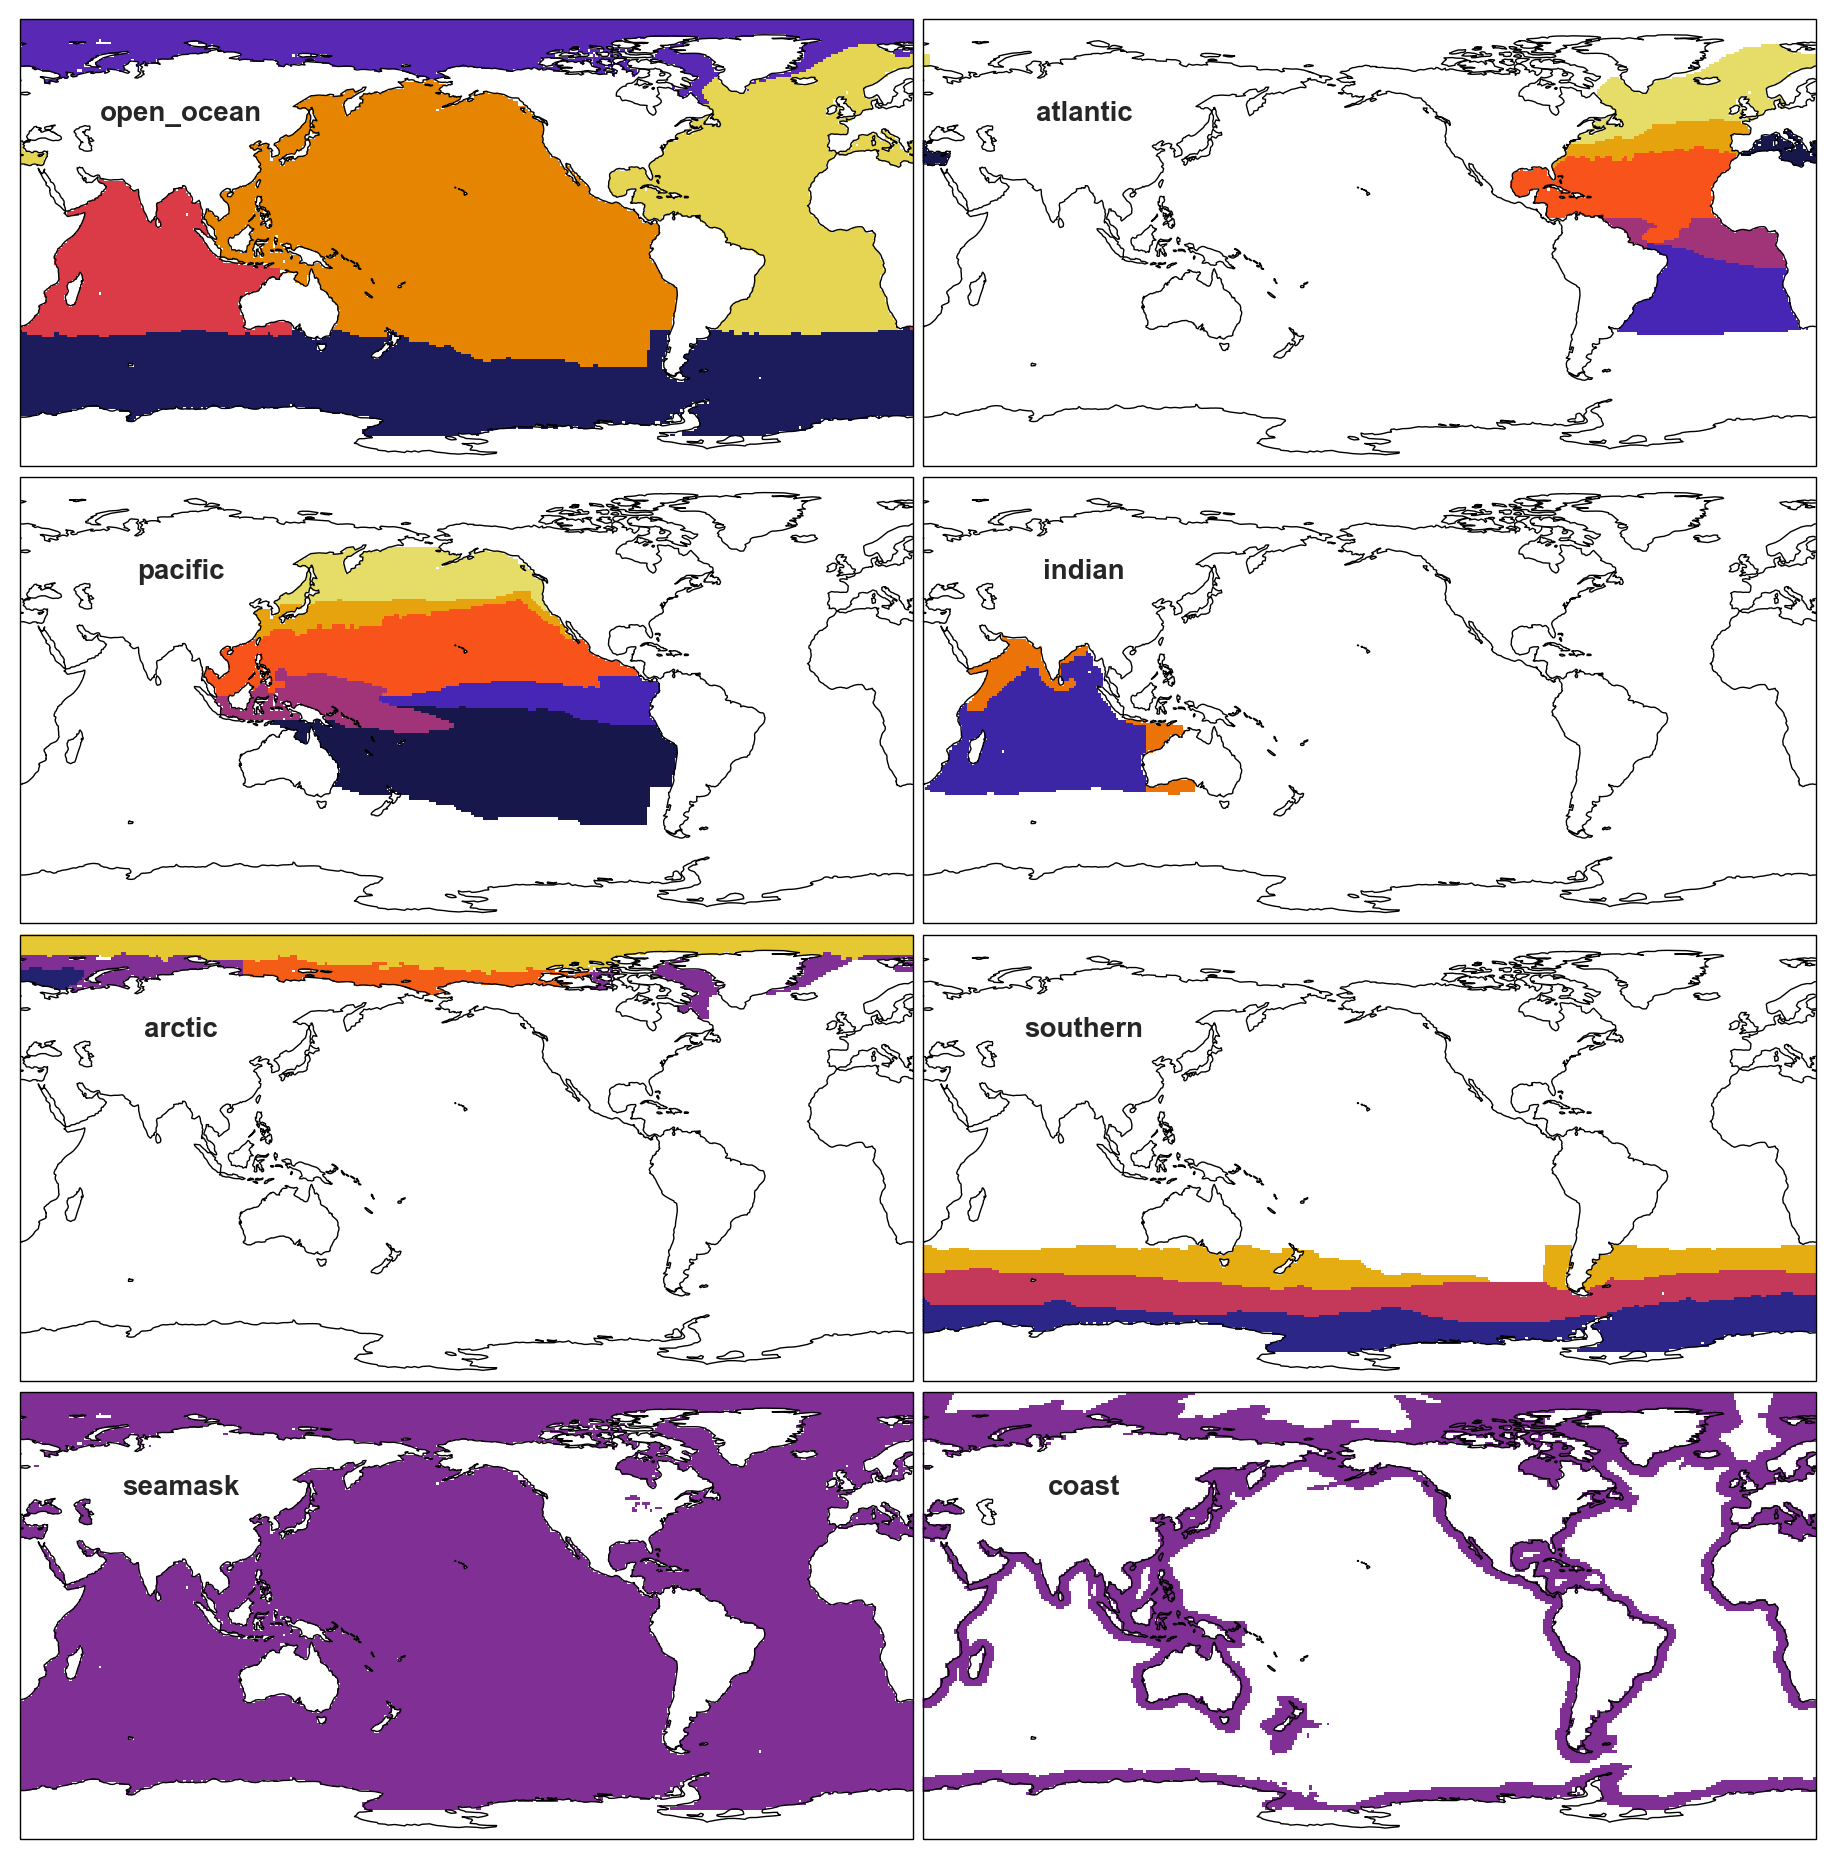

In [66]:
fig = figure(figsize=[9, 9.1], dpi=200)
for i, key in enumerate(xds):
    ax = splot.subplot_map(pos=421 + i, land_color='none')
    vmax = xds[key].max().values + 0.5
    xds[key].plot(ax=ax, cmap=cm.CMRmap_r, vmax=vmax, transform=pc, add_colorbar=False, rasterized=True)
    ax.text(90, 52, key, ha='center', va='center', transform=pc, weight='bold')
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.025, wspace=0.006)
fig.savefig(f'../img/{sname}.pdf', bbox_inches='tight', dpi=200)

# RECCAP regions - fix subregions overlap

In [4]:
import xarray as xr
import all_my_code as amc
import fsspec 

In [27]:
url = (
    "https://github.com/RECCAP2-ocean/R2-shared-resources/raw"
    "/master/data/regions/RECCAP2_region_masks_all_v20210412.nc")
mask = xr.open_dataset(fsspec.open(url).open())

## problem

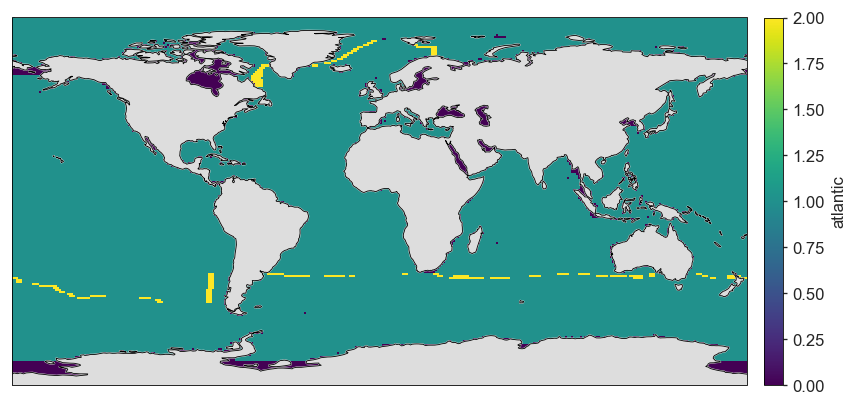

In [35]:
names = [s.split('.')[1].lower() for s in mask.open_ocean.region_names.split(',')]
xr.concat([(mask[r] > 0).astype(int) for r in names], 'regions').sum('regions').map(robust=False)

# Solution
Open ocean regions cannot overlap, so we use this as a mask to remove overlaps

In [36]:
new_mask = mask[['seamask', 'coast', 'open_ocean']]
new_mask['atlantic'] = mask.atlantic.where(mask.open_ocean == 1).fillna(0)
new_mask['pacific' ] = mask.pacific .where(mask.open_ocean == 2).fillna(0)
new_mask['indian'  ] = mask.indian  .where(mask.open_ocean == 3).fillna(0)
new_mask['arctic'  ] = mask.arctic  .where(mask.open_ocean == 4).fillna(0)
new_mask['southern'] = mask.southern.where(mask.open_ocean == 5).fillna(0)
new_mask = new_mask.astype('int8')

In [37]:
out = new_mask.to_netcdf_with_compression(
    '../data/regions/RECCAP2_region_masks_all_v20220412.nc', 
    compression='int8'
)

File already exists: ../data/regions/RECCAP2_region_masks_all_v20220412.nc


# Updated basins

In [ ]:
r2 = xr.open_dataset('/Users/luke/Data/cached/RECCAP2_region_masks_all_v20220412.nc')

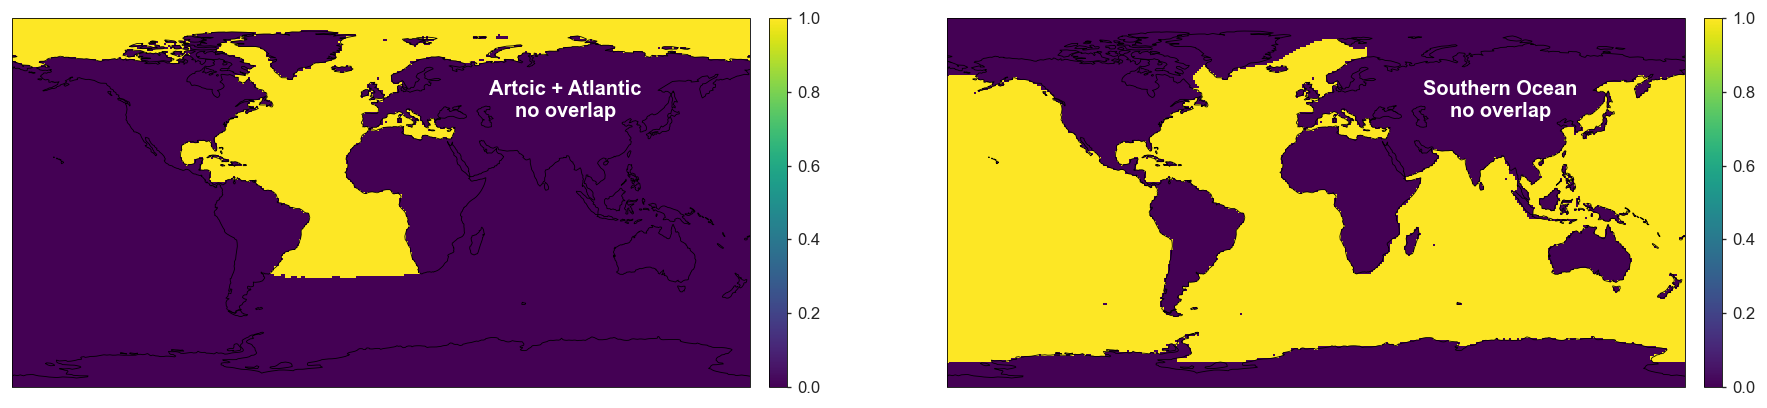

In [ ]:
img1 = ((r2.atlantic > 0) + (r2.arctic >0)).map(pos=121, robust=False)
img2 = ((r2.southern > 0) + (r2.atlantic > 0) + (r2.pacific > 0) + (r2.indian > 0)).map(pos=122, robust=False)

img1.set_title('Artcic + Atlantic\nno overlap', color='w')
img2.set_title('Southern Ocean\nno overlap', color='w')

plt.gcf().tight_layout()

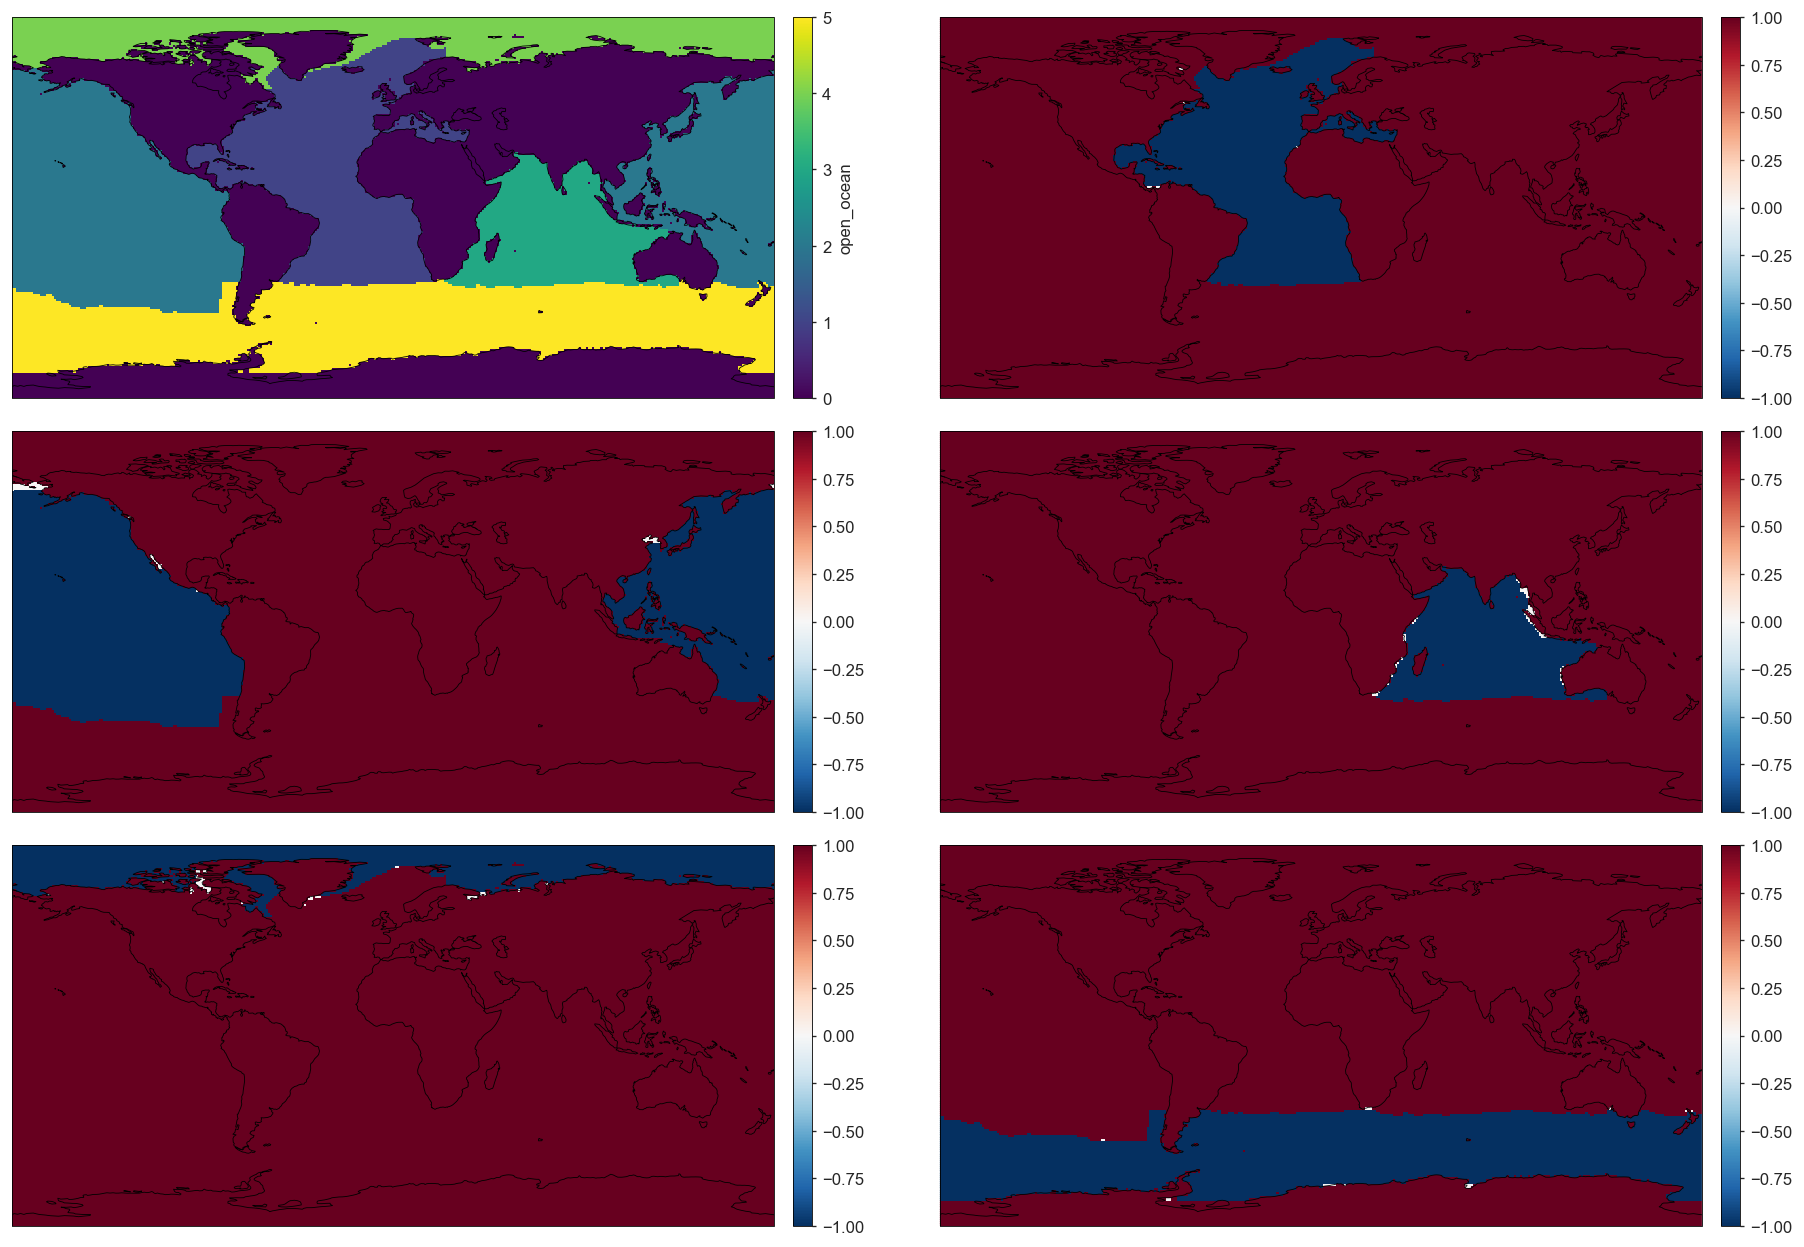

In [ ]:
r2.open_ocean.map(pos=321)
(-1 * ((r2.atlantic > 0).astype(int) + (r2.open_ocean == 1).astype(int)) + 1).map(pos=322, robust=False)
(-1 * ((r2.pacific  > 0).astype(int) + (r2.open_ocean == 2).astype(int)) + 1).map(pos=323, robust=False)
(-1 * ((r2.indian   > 0).astype(int) + (r2.open_ocean == 3).astype(int)) + 1).map(pos=324, robust=False)
(-1 * ((r2.arctic   > 0).astype(int) + (r2.open_ocean == 4).astype(int)) + 1).map(pos=325, robust=False)
(-1 * ((r2.southern > 0).astype(int) + (r2.open_ocean == 5).astype(int)) + 1).map(pos=326, robust=False)

fig = plt.gcf()
fig.tight_layout()

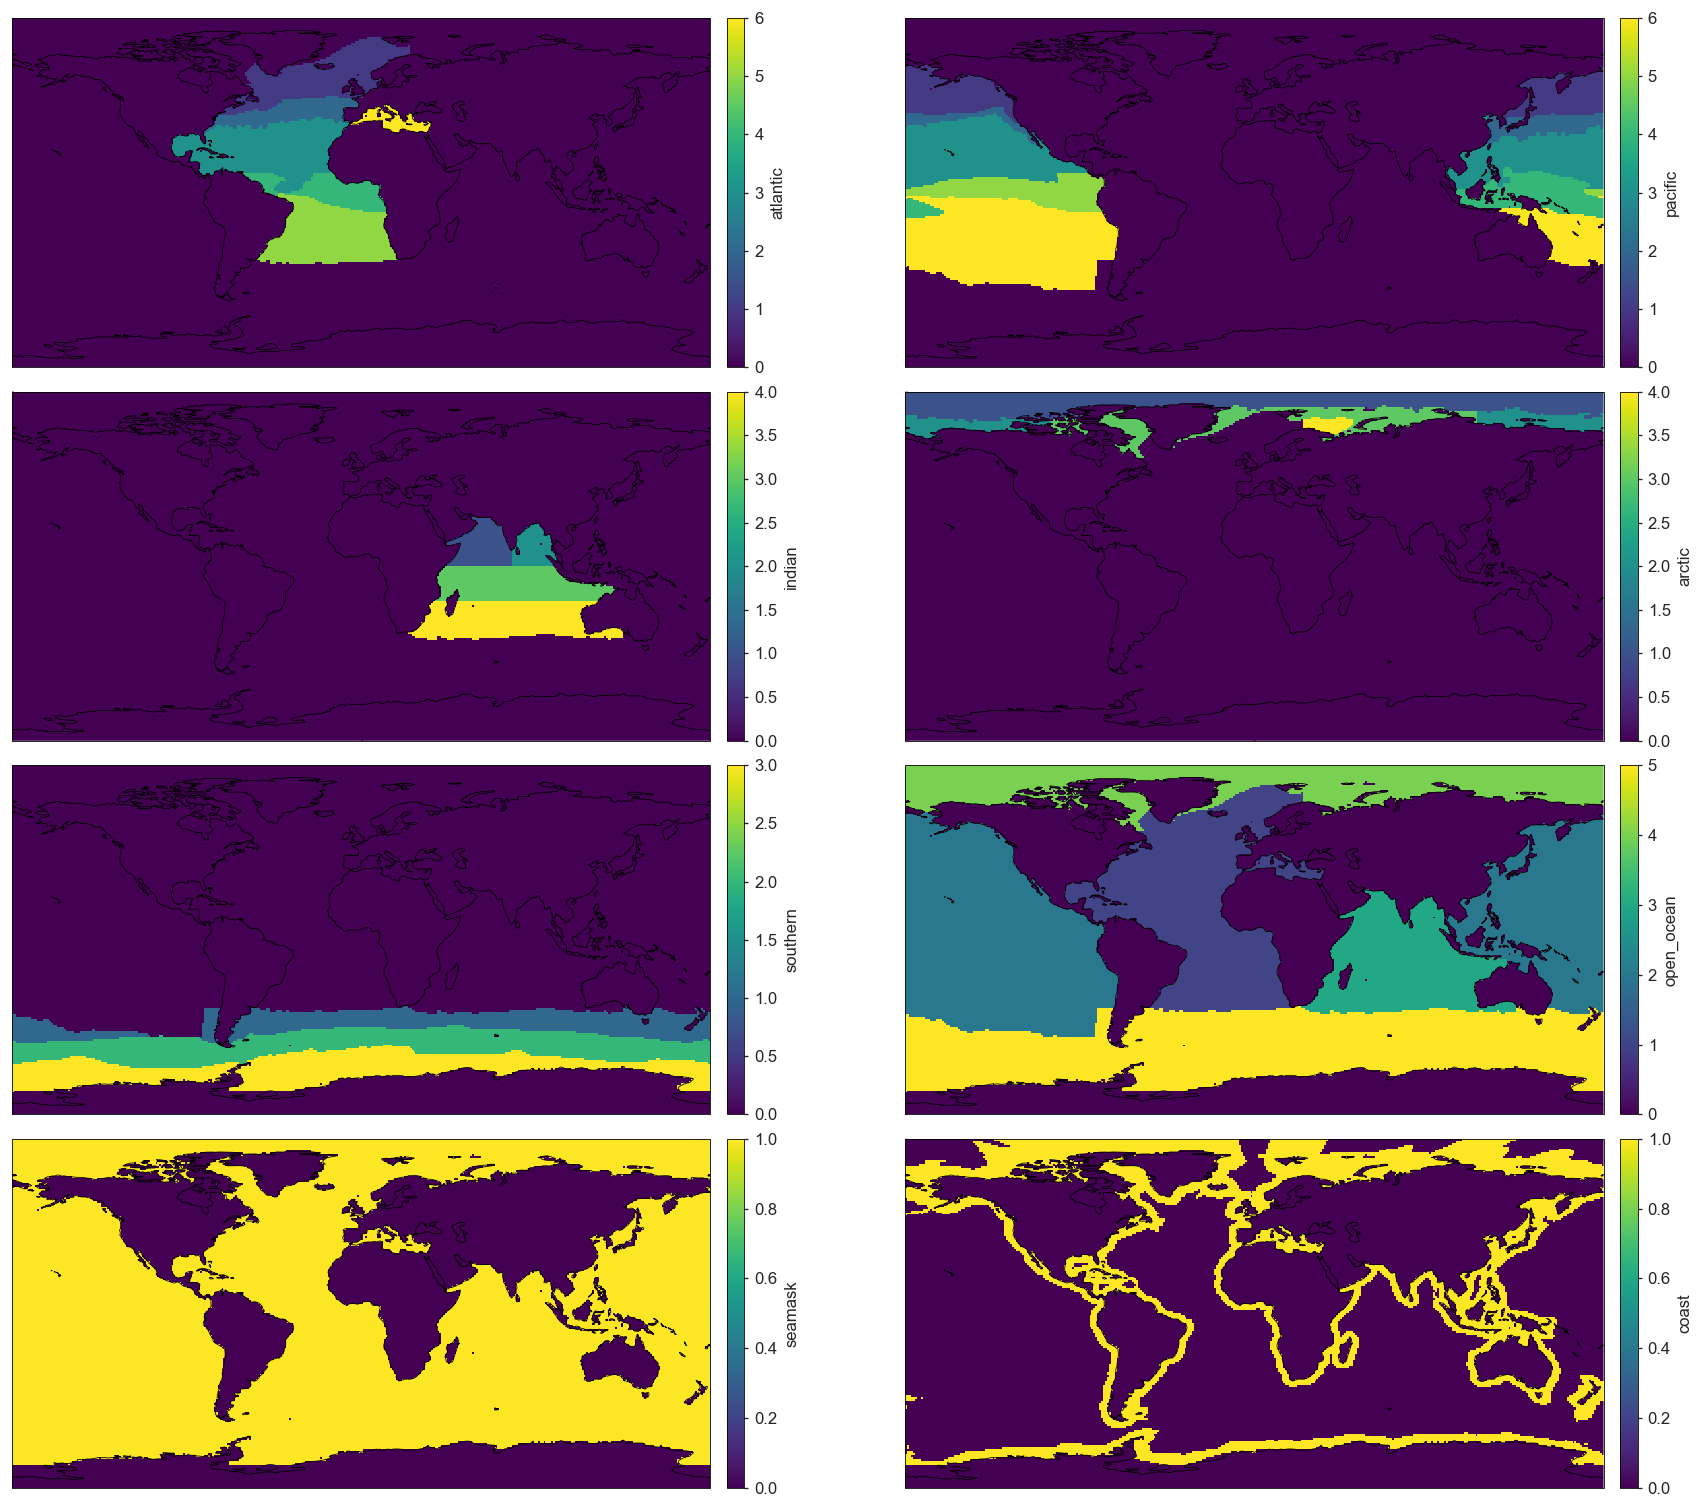

In [ ]:
NOW = pd.Timestamp.now()

r3 = r2.copy()
r3['atlantic'] = r2.atlantic.where(lambda x: x > 0).bfill('lat').where(r2.open_ocean == 1).astype("int8")
r3['pacific' ] = r2.pacific .where(lambda x: x > 0).ffill('lat').where(r2.open_ocean == 2).astype("int8")
r3['indian'  ] = r2.indian  .where(lambda x: x > 0).ffill('lon').bfill('lon').where(r2.open_ocean == 3).astype("int8")
r3['arctic'  ] = r2.arctic  .where(lambda x: x > 0).ffill('lon').bfill('lon').where(r2.open_ocean == 4).astype("int8")
r3['southern'] = r2.southern.where(lambda x: x > 0).ffill('lat').where(r2.open_ocean == 5).astype("int8")
r3['open_ocean'] = r2.open_ocean.where(r3.atlantic | r3.pacific | r3.indian | r3.arctic | r3.southern).fillna(0).astype("int8")
r3['seamask'] = r2.seamask.where(r3.open_ocean).fillna(0).astype("int8")
r3['coast'] = r2.coast.where(r3.open_ocean).fillna(0).astype('int8')

base = r3.indian > 0
r3['indian'] = xr.concat([
    ((base.lat > 0) & (base.lon < 78) & base).astype(int) * 1,  # arabian sea
    ((base.lat > 0) & (base.lon > 78) & base).astype(int) * 2,  # bay of bengal
    ((base.lat > -18) & (base.lat < 0) & base).astype(int) * 3,  # equatorial indian
    ((base.lat < -18) & base).astype(int) * 4,  # southern indian
], 'biome').sum('biome').astype("int8")

for key in r3:
    if 'region_names' in r2[key].attrs:
        r3[key].attrs = dict(region_name=r2[key].attrs.get('region_names', ''))
    else:
        r3[key].attrs = dict(r2[key].attrs)

r3['indian'] = r3.indian.assign_attrs(region_name="1.Arabian Sea, 2.Bay of Bengal, 3.Equatorial Indian, 4.Southern Indian")

r3.attrs = dict(date=f"{NOW.strftime('%Y-%m-%d')}", contact="gregorl@ethz.ch", **r2.attrs)

r3.atlantic.map(robust=False, pos=421)
r3.pacific .map(robust=False, pos=422)
r3.indian  .map(robust=False, pos=423)
r3.arctic  .map(robust=False, pos=424)
r3.southern.map(robust=False, pos=425)
r3.open_ocean.map(robust=False, pos=426)
r3.seamask.map(robust=False, pos=427)
r3.coast.map(robust=False, pos=428)

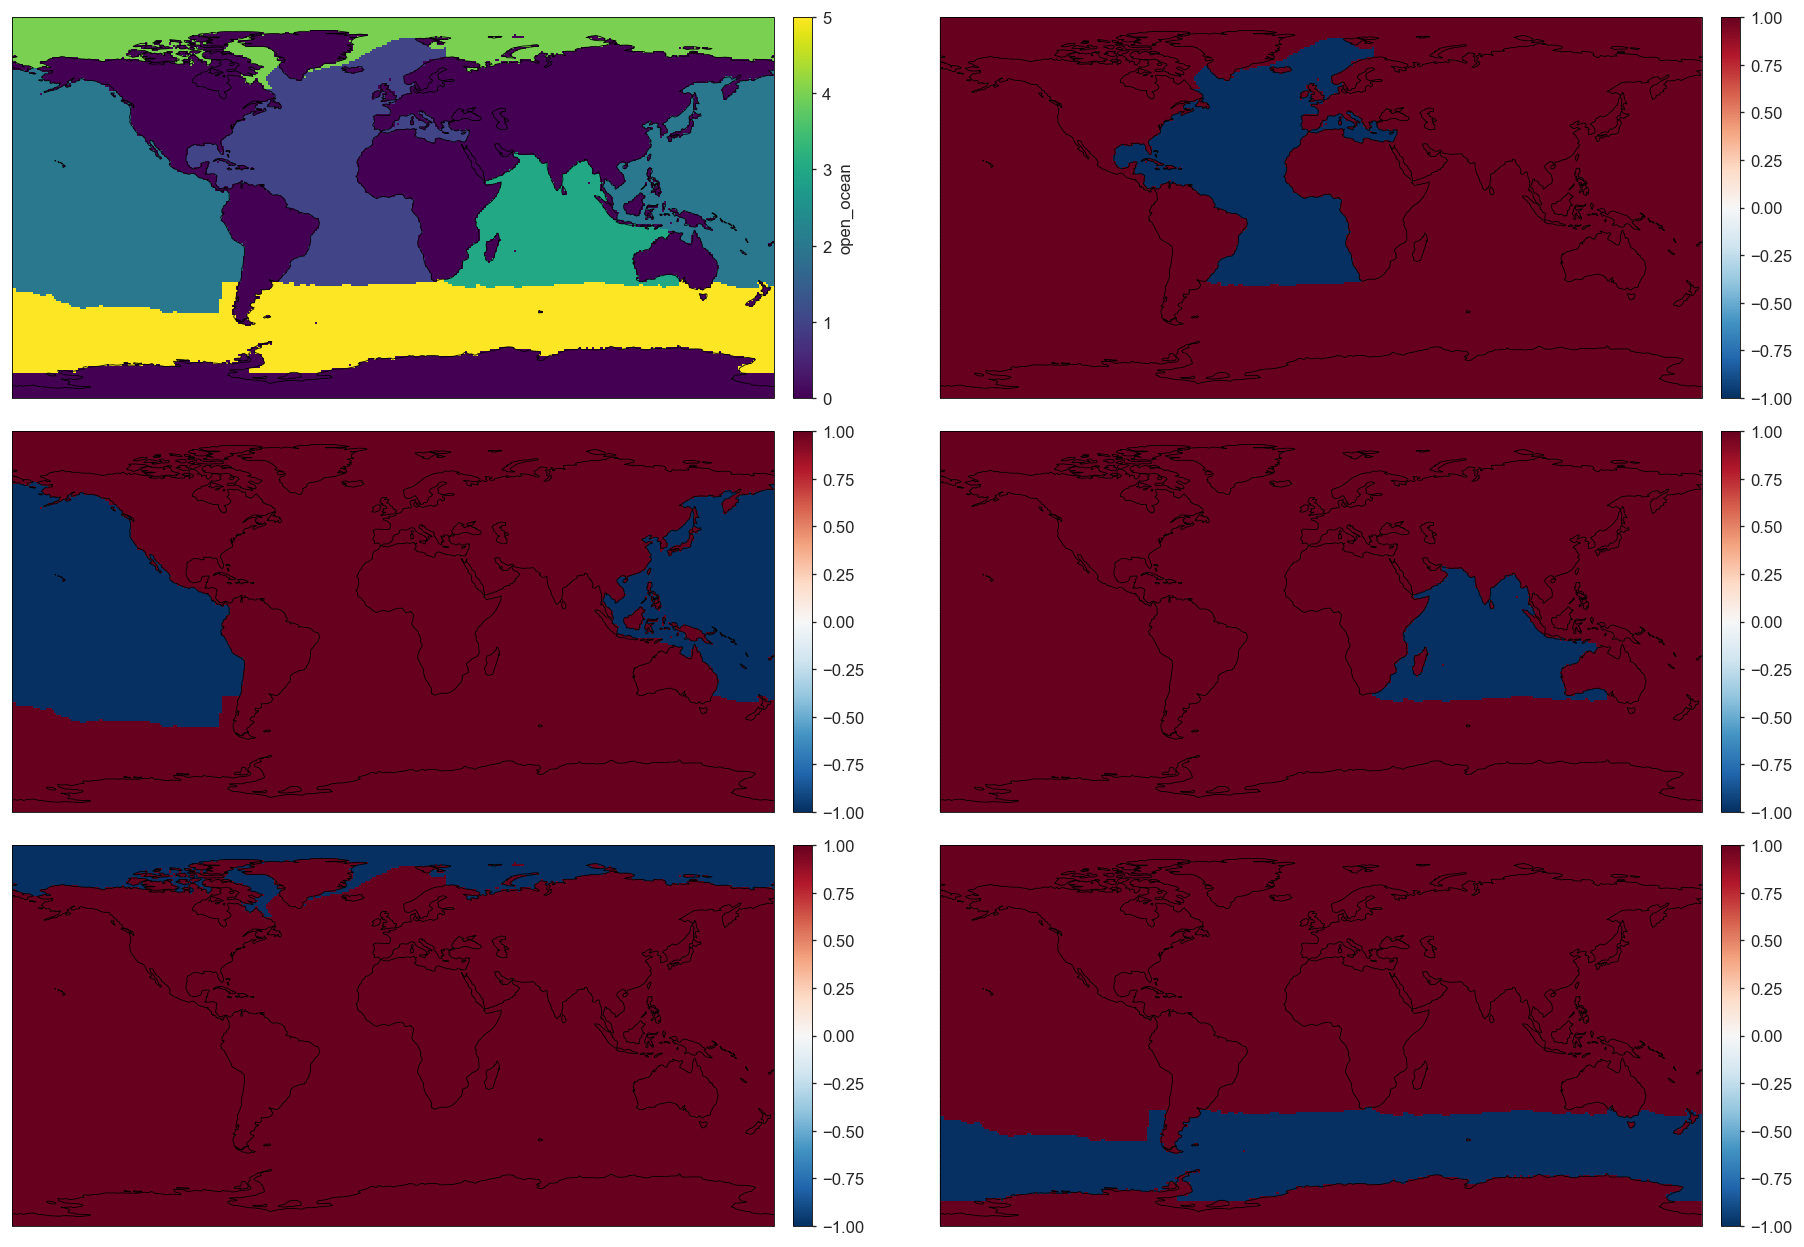

In [ ]:
r3.open_ocean.map(pos=321)
(-1 * ((r3.atlantic > 0).astype(int) + (r3.open_ocean == 1).astype(int)) + 1).map(pos=322, robust=False)
(-1 * ((r3.pacific  > 0).astype(int) + (r3.open_ocean == 2).astype(int)) + 1).map(pos=323, robust=False)
(-1 * ((r3.indian   > 0).astype(int) + (r3.open_ocean == 3).astype(int)) + 1).map(pos=324, robust=False)
(-1 * ((r3.arctic   > 0).astype(int) + (r3.open_ocean == 4).astype(int)) + 1).map(pos=325, robust=False)
(-1 * ((r3.southern > 0).astype(int) + (r3.open_ocean == 5).astype(int)) + 1).map(pos=326, robust=False)

fig = plt.gcf()
fig.tight_layout()

In [ ]:
r3.to_netcdf('../data/regions/RECCAP2_region_masks_all_v20220620.nc')